In [1]:
######################################################################
# Code produced by Ayden McCarthy
# Manuscript Title: "Machine Learning Models Predict Assessment Outcomes 
#                    From Military Physical Employment Standards Via a 
#                    Physical Test Battery"
# Program of Study: PhD Candidacy
# Institution: Macquarie University
# Year: 2024
######################################################################

######################################################################
# Note for Users:
# This code is intended for use within Python JupyterLab.
# It requires data to be set up according to the instructions 
# outlined in the manuscript. Users can follow the code comments to 
# understand each step of the analysis.
# Please ensure that you replace the placeholder CSV file names in 
# the code with the names of your specific data files to run the code 
# successfully.
######################################################################


In [2]:
# Import necessary libraries and modules for all machine learning models produced in the manuscript
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import warnings
import time
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from sklearn.exceptions import ConvergenceWarning
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Create HTML for text with black color
html_text = """
<div style='font-size:70px; font-weight:bold; text-align:center; color: black;'>
    Support Vector Regression Model
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

*** Processing SVR with optimal hyperparameters... ***
Best parameters found: {'C': 100.0, 'degree': 2, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'sigmoid'}
*** Processing Sequential Backward Selection... ***


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.


Selected feature indices: [0, 4, 6, 10, 11, 13, 14]
Selected feature names: Index(['IMTP_Peak Vertical Force [N] ', 'Avg_Bicep',
       'Combined_Left_Right_HABD', 'LCMJ_Velocity at Peak Power [m/s]', 'Sex',
       'LCMJ_Concentric Peak Velocity [m/s]', 'LCMJ_Peak Power [W]'],
      dtype='object')
Number of selected features: 7
RMSE with Optimal Features from SBS: 3.6676022169792475


ExactExplainer explainer: 29it [00:13,  2.00it/s]                        


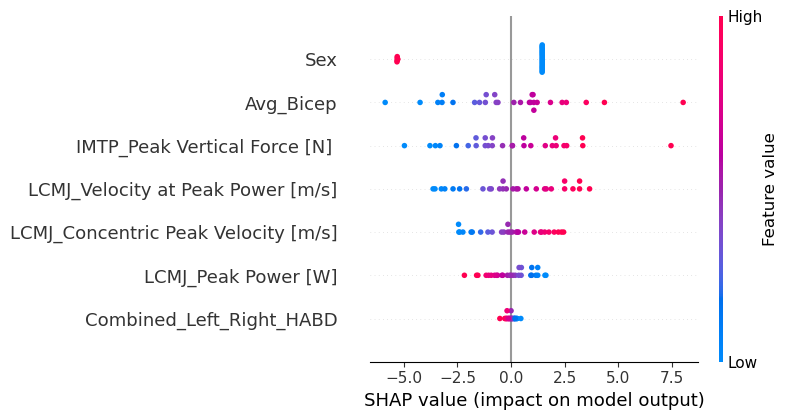

Feature Importance based on SHAP values:
                               Feature  SHAP Value
4                                  Sex    2.273704
1                            Avg_Bicep    2.163405
0        IMTP_Peak Vertical Force [N]     2.075660
3    LCMJ_Velocity at Peak Power [m/s]    1.820746
5  LCMJ_Concentric Peak Velocity [m/s]    1.267087
6                  LCMJ_Peak Power [W]    0.830414
2             Combined_Left_Right_HABD    0.164048
Analysis Complete.


In [4]:
# Load dataset
df = pd.read_csv('Training_Set_Reduced_with_Important_Features.csv') ###Please change to your own dataset.

# Separate features (predictors) and target variable
X = df.drop(columns=['Weight Lifted (Kg)']) ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.
y = df['Weight Lifted (Kg)'] ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


param_grid_svr = {
    'C': np.logspace(-4, 4, 9),  # Reduced granularity
    'epsilon': np.logspace(-4, 1, 6),  # Reduced granularity
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],  # Reduced the range slightly
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))  # Reduced granularity
}


# Initialize SVR model
svr = SVR()

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Perform Grid Search CV for hyperparameter tuning
print("*** Processing SVR with optimal hyperparameters... ***")
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_scaled, y)

# Best hyperparameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found:", best_params_svr)

# Train the SVR model with the best hyperparameters
svr_best = SVR(**best_params_svr)

# Initialise Sequential Feature Selector with backward selection
sfs = SFS(svr_best, 
          k_features=(1, X_scaled.shape[1]),  # Range: from 1 feature to the total number of features
          forward=False,  # Set to False for backward selection
          floating=True,  # Enable floating
          scoring='neg_mean_squared_error', 
          cv=loo,  # Using Leave-One-Out cross-validation
          n_jobs=-1)

# Fit SFS
print("*** Processing Sequential Backward Selection... ***")
sfs = sfs.fit(X_scaled, y)

# Get the indices of the selected features
selected_indices = list(sfs.k_feature_idx_)
print("Selected feature indices:", selected_indices)

# Get the selected feature names
selected_feature_names = X.columns[selected_indices]
print("Selected feature names:", selected_feature_names)

# Print the number of selected features
print(f"Number of selected features: {len(selected_indices)}")

# Train the model with the selected features
X_optimal_sbs = X_scaled[:, selected_indices]
svr_best.fit(X_optimal_sbs, y)

# Evaluate the model performance
y_pred_optimal_sbs = svr_best.predict(X_optimal_sbs)
rmse_optimal_sbs = np.sqrt(mean_squared_error(y, y_pred_optimal_sbs))
print("RMSE with Optimal Features from SBS:", rmse_optimal_sbs)

# Initialize SHAP Explainer to interpret the model's predictions
explainer = shap.Explainer(svr_best.predict, shap.sample(X_optimal_sbs, 100))

# Calculate SHAP values for the selected features
shap_values = explainer(X_optimal_sbs)
shap.summary_plot(shap_values, X_optimal_sbs, feature_names=selected_feature_names)

# Calculate the mean absolute SHAP values to understand the average impact of each feature
shap_sum = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their corresponding SHAP values
feature_importance = pd.DataFrame(list(zip(selected_feature_names, shap_sum)), columns=['Feature', 'SHAP Value'])
feature_importance = feature_importance.sort_values(by='SHAP Value', ascending=False)

print("Feature Importance based on SHAP values:")
print(feature_importance)

# Store results
LOO_SVR_Seq_model_results = {
    'SVR': {
        'RMSE Optimal': rmse_optimal_sbs,
        'Optimal Features': selected_feature_names.tolist(),
        'Selected Feature Indices': selected_indices,  # Store the indices of the selected features
        'Number of Selected Features': len(selected_indices),  # Include the number of selected features
        'Model': svr_best,
        'Feature Importance': feature_importance
    }
}

print("Analysis Complete.")



In [5]:
# Create HTML for text with black color
html_text = """
<div style='font-size:60px; font-weight:bold; text-align:center; color: black;'>
    Optimal features saved to .csv file
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

In [6]:
# Loop through each model in LOO_SVR_model_results
for model_name, model_info in LOO_SVR_Seq_model_results.items():
    # Extract the selected features - Check if 'Optimal Features' exists in the dictionary to avoid KeyError
    if 'Optimal Features' in model_info:
        selected_features = model_info['Optimal Features']
    else:
        print(f"No 'Optimal Features' found for {model_name}.")
        continue

    # Add 'Weight Lifted (Kg)' to the list of features
    # Ensure that 'Weight Lifted (Kg)' is not already in the list to avoid duplication
    if 'Weight Lifted (Kg)' not in selected_features: ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.
        selected_features_with_target = list(selected_features) + ['Weight Lifted (Kg)'] ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.
    else:
        selected_features_with_target = list(selected_features)

    # Filter the original DataFrame based on these features
    # Ensure the features exist in the DataFrame to avoid KeyError
    missing_features = [feature for feature in selected_features_with_target if feature not in df.columns]
    if missing_features:
        print(f"The following features are missing in the DataFrame for {model_name}: {missing_features}")
        continue
    df_filtered = df[selected_features_with_target]

    # Save the filtered data to a CSV file
    # Using a safe string for the filename (replacing spaces and slashes)
    safe_model_name = model_name.replace(' ', '_').replace('/', '_')
    filename_filtered = f'{safe_model_name}_optimal_features_data_SVR_LOO.csv'
    df_filtered.to_csv(filename_filtered, index=False)

    # Save the model results (including feature importance and RMSE) to a CSV file
    filename_results = f'{safe_model_name}_model_results_SVR_LOO.csv'
    model_info_df = pd.DataFrame(model_info.items(), columns=['Metric', 'Value'])
    model_info_df.to_csv(filename_results, index=False)

    print(f"Saved data for {model_name} with optimal features to {filename_filtered}")
    print(f"Saved model results for {model_name} to {filename_results}")

print("Data saving process complete.")


Saved data for SVR with optimal features to SVR_optimal_features_data_SVR_LOO.csv
Saved model results for SVR to SVR_model_results_SVR_LOO.csv
Data saving process complete.


In [7]:
# Create HTML for text with black color
html_text = """
<div style='font-size:60px; font-weight:bold; text-align:center; color: black;'>
    Optimise Parameters
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

*** Tuning hyperparameters for SVR (LOO)... ***
Fitting 28 folds for each of 7680 candidates, totalling 215040 fits
Best parameters found: {'C': 1291.5496650148827, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Root Mean Squared Error (LOO SVR): 3.493787819635558


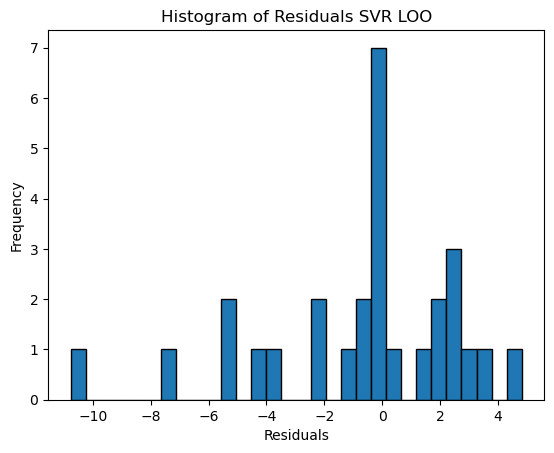

In [8]:
# Load the data
df = pd.read_csv('SVR_optimal_features_data_SVR_LOO.csv')  # Adjust the file name if needed

# Separate features and target variable
X = df.drop(['Weight Lifted (Kg)'], axis=1) ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.
y = df['Weight Lifted (Kg)'] ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a more extensive parameter grid for SVR
param_grid_svr = {
    'C': np.logspace(-4, 4, 10),  # Reduced granularity
    'epsilon': np.logspace(-4, 1, 6),  # Reduced granularity
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],  # Reduced the range slightly
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))  # Reduced granularity
}

# Initialize SVR model
svr = SVR()

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Perform Grid Search CV for hyperparameter tuning
print("*** Tuning hyperparameters for SVR (LOO)... ***")
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_svr.fit(X_scaled, y)

# Best hyperparameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found:", best_params_svr)

# Train the SVR model with the best hyperparameters
svr_best = SVR(**best_params_svr)
svr_best.fit(X_scaled, y)

# Make predictions
y_pred_svr = svr_best.predict(X_scaled)

# Calculate RMSE
rmse_svr = np.sqrt(mean_squared_error(y, y_pred_svr))
print("Root Mean Squared Error (LOO SVR):", rmse_svr)

# Calculate residuals
residuals_svr = y - y_pred_svr

# Plot a histogram of the residuals
plt.hist(residuals_svr, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals SVR LOO')
plt.show()


In [9]:
# Create HTML for text with black color
html_text = """
<div style='font-size:60px; font-weight:bold; text-align:center; color: black;'>
    Testing Phase - Unseen Data
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

Root Mean Squared Error on Testing Data (SVR LOO): 1.772354446696828


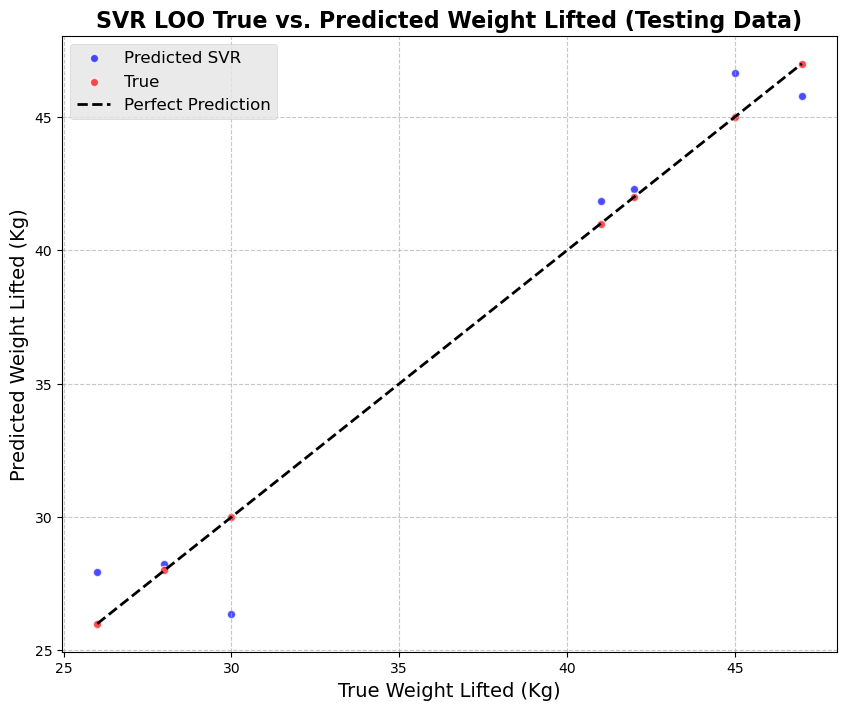

<Figure size 640x480 with 0 Axes>

In [10]:
# Load the testing dataset
df_testing = pd.read_csv('Testing_Set.csv') ###Please change to your own dataset.

# If you have categorical features, ensure to encode them as you did in the training dataset
#df_testing['Sex'] = df_testing['Sex'].map({'M': 0, 'F': 1})

# Make sure to use the same feature set as the one used for training
X_testing = df_testing[X.columns]

# Standardize features (use the same scaler fitted on the training data)
X_testing_scaled = scaler.transform(X_testing)

# Use the trained SVR model to make predictions on the testing dataset
y_pred_testing_svr = svr_best.predict(X_testing_scaled)

# Add the predicted values to the testing dataset
df_testing['Predicted_Weight_Lifted_SVR'] = y_pred_testing_svr

# Calculate RMSE for testing data (if true target values are available)
true_y_testing = df_testing['Weight Lifted (Kg)'] ######## Your outcome variable is to be placed where 'Weight Lifted (Kg)' is. This was the lift-to-place results.
rmse_testing_svr = np.sqrt(mean_squared_error(true_y_testing, y_pred_testing_svr))
print("Root Mean Squared Error on Testing Data (SVR LOO):", rmse_testing_svr)

# Plot the true vs. predicted values with improved styling
plt.figure(figsize=(10, 8))

# Scatter plot for the predicted values
plt.scatter(true_y_testing, y_pred_testing_svr, alpha=0.7, label='Predicted SVR', color='blue', edgecolors='w')

# Scatter plot for the true values
plt.scatter(true_y_testing, true_y_testing, alpha=0.7, label='True', color='red', edgecolors='w')

# Diagonal line indicating perfect predictions
plt.plot([true_y_testing.min(), true_y_testing.max()], [true_y_testing.min(), true_y_testing.max()], 'k--', lw=2, label='Perfect Prediction')

# Styling the plot
plt.style.use('ggplot')
plt.xlabel('True Weight Lifted (Kg)', fontsize=14)
plt.ylabel('Predicted Weight Lifted (Kg)', fontsize=14)
plt.title('SVR LOO True vs. Predicted Weight Lifted (Testing Data)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Display the plot
plt.show()

# Save the predictions and the plot to files
df_testing.to_csv('Testing_Set_Predictions_SVR_LOO.csv', index=False)
plt.savefig('True_vs_Predicted_Plot_SVR_LOO.png', format='png')
